In [1]:
import numpy as np
import pandas as pd
import pyrsm as rsm
import re
import pandas as pd
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer 
ps = PorterStemmer()
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
import multiprocessing
from sklearn.model_selection import train_test_split
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from tqdm import tqdm
from math import log
import os
import string
from collections import Counter
import itertools
from gensim.models import word2vec
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train

,id,attributes.HappyHour,attributes.Ambience,hours.Tuesday,postal_code,attributes.AgesAllowed,attributes.GoodForDancing,attributes.OutdoorSeating,hours.Saturday,attributes.Corkage,longitude,name,attributes.BusinessAcceptsCreditCards,attributes.RestaurantsTableService,attributes.RestaurantsReservations,hours.Friday,attributes.RestaurantsPriceRange2,attributes.WiFi,attributes.ByAppointmentOnly,attributes.Music,attributes.NoiseLevel,attributes.BYOB,state,attributes.Alcohol,attributes.HasTV,attributes,attributes.BYOBCorkage,hours.Wednesday,hours.Sunday,attributes.RestaurantsGoodForGroups,attributes.Open24Hours,attributes.BusinessParking,attributes.DogsAllowed,attributes.HairSpecializesIn,review_count,is_open,attributes.Caters,attributes.CoatCheck,attributes.BikeParking,hours.Monday,attributes.WheelchairAccessible,city,stars,attributes.DriveThru,attributes.RestaurantsTakeOut,latitude,attributes.Smoking,business_id,attributes.RestaurantsCounterService,hours.Thursday,attributes.RestaurantsAttire,attributes.BestNights,attributes.AcceptsInsurance,attributes.RestaurantsDelivery,attributes.DietaryRestrictions,attributes.BusinessAcceptsBitcoin,address,attributes.GoodForKids,attributes.GoodForMeal,hours,label,review
0,0,b'True',"b""{'romantic': False, 'intimate': False, 'clas...",b'15:0-2:0',b'44107',NaN,NaN,b'False',b'11:30-2:0',NaN,-81.820568,b'Rush Inn',b'True',NaN,b'False',b'11:30-2:0',b'2',"b""u'no'""",NaN,"b""{'dj': False, 'background_music': False, 'no...","b""u'loud'""",NaN,b'OH',"b""u'full_bar'""",b'True',"{'WiFi': ""u'no'"", 'Caters': 'True', 'HappyHour...",NaN,b'15:0-2:0',NaN,b'True',NaN,"b""{'garage': False, 'street': True, 'validated...",NaN,NaN,70,1,b'True',NaN,b'True',b'16:0-2:0',NaN,b'Lakewood',4.0,NaN,b'True',41.484197,"b""u'outdoor'""",b'elpC4MTNzvMphY8xOjltAg',NaN,b'11:30-2:0',"b""u'casual'""","b""{'monday': False, 'tuesday': False, 'friday'...",NaN,b'False',NaN,NaN,b'17800 Detroit Ave',b'False',"b""{'dessert': False, 'latenight': False, 'lunc...","{'Monday': '16:0-2:0', 'Tuesday': '15:0-2:0', ...",american (traditional),"So, we stopped here on our way to the Side Que..."
1,1,NaN,"b""{'romantic': False, 'intimate': False, 'tour...",b'11:0-21:0',b'85042',NaN,NaN,b'True',b'11:0-20:30',NaN,-112.032893,b'GreenMix',b'True',NaN,b'False',b'11:0-21:0',b'2',"b""u'no'""",NaN,NaN,"b""u'quiet'""",NaN,b'AZ',"b""u'none'""",b'False',"{'WiFi': ""u'no'"", 'HasTV': 'False', 'GoodForMe...",NaN,b'11:0-21:0',b'11:0-20:30',b'True',NaN,"b""{'garage': False, 'street': False, 'validate...",NaN,NaN,181,1,b'True',NaN,b'True',b'11:0-21:0',NaN,b'Phoenix',3.5,NaN,b'True',33.379283,NaN,b'BBTkC1Z3ZnEE916SkCONIg',NaN,b'11:0-21:0',"b""u'casual'""",NaN,NaN,b'False',NaN,b'False',"b'2160 E Baseline Rd, Ste 128'",b'True',"b""{'dessert': False, 'latenight': False, 'lunc...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",american (new),This is our go-to healthy spot! The food is al...
2,2,NaN,NaN,b'11:0-21:0',b'M4M 3G6',NaN,NaN,NaN,b'11:0-21:0',NaN,-79.339163,b'BarBurrito - Gerrard',NaN,NaN,b'False',b'11:0-21:0',NaN,NaN,NaN,NaN,NaN,NaN,b'ON',NaN,NaN,"{'RestaurantsTakeOut': 'False', 'RestaurantsRe...",NaN,b'11:0-21:0',b'11:0-18:0',NaN,NaN,NaN,NaN,NaN,6,1,NaN,NaN,NaN,b'11:0-21:0',NaN,b'Toronto',3.0,NaN,b'False',43.669144,NaN,b'i3oRRwl3RWOxKfTtiJbliw',NaN,b'11:0-21:0',NaN,NaN,NaN,NaN,NaN,NaN,b'1000 Gerrard St E',NaN,NaN,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",mexican,Food court meal at Gerrard Square. It's been ...
3,3,NaN,"b""{'romantic': False, 'intimate': False, 'clas...",NaN,b'89146',NaN,NaN,b'False',NaN,NaN,-115.242714,b'SalvaMex',b'True',b'True',b'False',NaN,b'1',"b""'no'""",NaN,NaN,"b""'quiet'""",NaN,b'NV',"b""'none'""",b'True',"{'OutdoorSeating': 'False', 'Ambience': ""{'rom...",NaN,NaN,NaN,b'True',NaN,"b""{'garage': False, 'street': False, 'validate...",NaN,NaN,6,0,b'True',NaN,NaN,NaN,NaN,b'Las Vegas',4.0,NaN,b'True',36.159527,NaN,b'6jh0A5KphylHbE5VMJ8zIA',NaN,NaN,"b""'casual'""",NaN,NaN,b'True',NaN,NaN,b'6700 W Charleston Blvd',b'True',

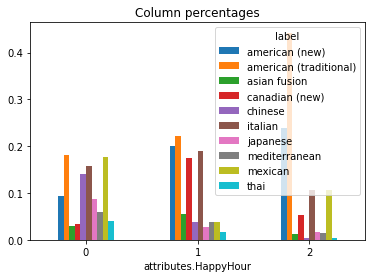

In [3]:
# attributes.HappyHour: True --> 2; False -->1; NaN --> 0
train["attributes.HappyHour"] = train["attributes.HappyHour"].fillna(value=0)
train["attributes.HappyHour"] = train["attributes.HappyHour"].apply(lambda x: 2 if x=="b'True'" else (1 if x=="b'False'" else 0))

test["attributes.HappyHour"] = test["attributes.HappyHour"].fillna(value=0)
test["attributes.HappyHour"] = test["attributes.HappyHour"].apply(lambda x: 2 if x=="b'True'" else (1 if x=="b'False'" else 0))

ct = rsm.cross_tabs(train, "label", "attributes.HappyHour")
ct.plot(output = "perc_col")

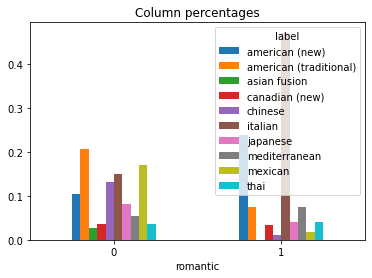

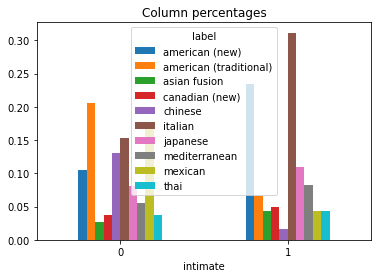

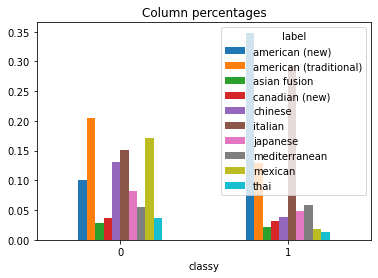

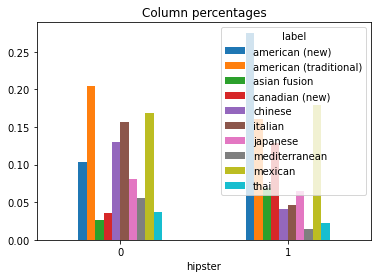

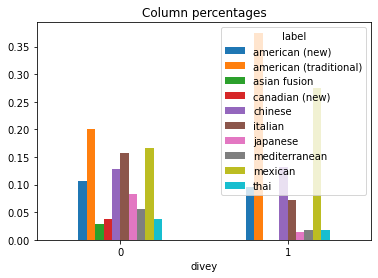

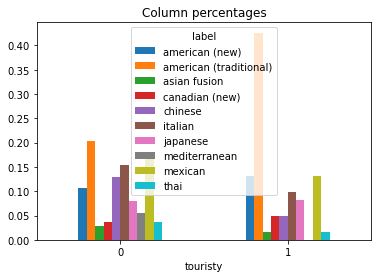

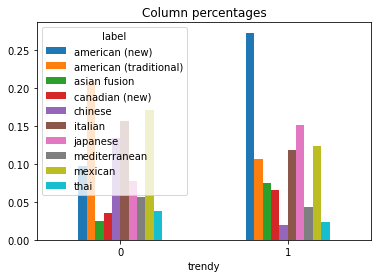

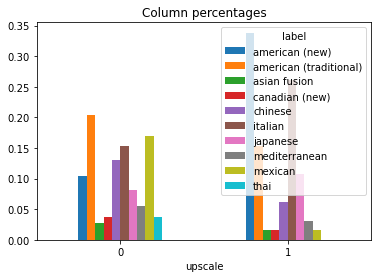

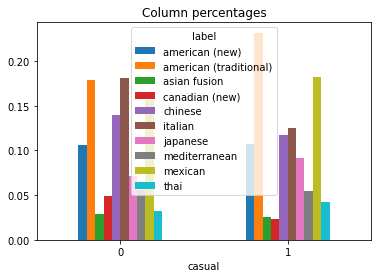

In [4]:
# attributes.Ambience: Extract True/False from text; Fill NaN with 0

for df in [train, test]:
    df["romantic"] = df["attributes.Ambience"].str.extract(r"'romantic':\s(\w{4,5})")
    df["intimate"] = df["attributes.Ambience"].str.extract(r"'intimate':\s(\w{4,5})")
    df["classy"] = df["attributes.Ambience"].str.extract(r"'classy':\s(\w{4,5})")
    df["hipster"] = df["attributes.Ambience"].str.extract(r"'hipster':\s(\w{4,5})")
    df["divey"] = df["attributes.Ambience"].str.extract(r"'divey':\s(\w{4,5})")
    df["touristy"] = df["attributes.Ambience"].str.extract(r"'touristy':\s(\w{4,5})")
    df["trendy"] = df["attributes.Ambience"].str.extract(r"'trendy':\s(\w{4,5})")
    df["upscale"] = df["attributes.Ambience"].str.extract(r"'upscale':\s(\w{4,5})")
    df["casual"] = df["attributes.Ambience"].str.extract(r"'casual':\s(\w{4,5})")

for df in [train,test]:
    df["romantic"] = df["romantic"].apply(lambda x: 1 if x == "True" else 0)
    df["intimate"] = df["intimate"].apply(lambda x: 1 if x == "True" else 0)
    df["classy"] = df["classy"].apply(lambda x: 1 if x == "True" else 0)
    df["hipster"] = df["hipster"].apply(lambda x: 1 if x == "True" else 0)
    df["divey"] = df["divey"].apply(lambda x: 1 if x == "True" else 0)
    df["touristy"] = df["touristy"].apply(lambda x: 1 if x == "True" else 0)
    df["trendy"] = df["trendy"].apply(lambda x: 1 if x == "True" else 0)
    df["upscale"] = df["upscale"].apply(lambda x: 1 if x == "True" else 0)
    df["casual"] = df["casual"].apply(lambda x: 1 if x == "True" else 0)

train.drop(["attributes.Ambience"], axis=1, inplace = True)
test.drop(["attributes.Ambience"], axis=1, inplace = True)  

ct = rsm.cross_tabs(train, "label", "romantic")
ct.plot(output = "perc_col")

ct = rsm.cross_tabs(train, "label", "intimate")
ct.plot(output = "perc_col")

ct = rsm.cross_tabs(train, "label", "classy")
ct.plot(output = "perc_col")

ct = rsm.cross_tabs(train, "label", "hipster")
ct.plot(output = "perc_col")

ct = rsm.cross_tabs(train, "label", "divey")
ct.plot(output = "perc_col")

ct = rsm.cross_tabs(train, "label", "touristy")
ct.plot(output = "perc_col")

ct = rsm.cross_tabs(train, "label", "trendy")
ct.plot(output = "perc_col")

ct = rsm.cross_tabs(train, "label", "upscale")
ct.plot(output = "perc_col")

ct = rsm.cross_tabs(train, "label", "casual")
ct.plot(output = "perc_col")

In [5]:
# Extract start and end hour on Tuesday
#train["start_hour_Tuesday"] = train["hours.Tuesday"].str.extract(r"b'(\w{1,2})").astype(str)
#train["start_hour_Tuesday"] = pd.to_datetime(train["start_hour_Tuesday"],format= '%H' ).dt.time
#test["start_hour_Tuesday"] = test["hours.Tuesday"].str.extract(r"b'(\w{1,2})").astype(str)

#train["end_hour_Tuesday"] = train["hours.Tuesday"].str.extract(r"-(\w{1,2})").astype(str)
#test["end_hour_Tuesday"] = test["hours.Tuesday"].str.extract(r"-(\w{1,2})").astype(str)

train.drop(["hours.Tuesday"], axis=1, inplace = True)
test.drop(["hours.Tuesday"], axis=1, inplace = True)

In [6]:
# Extract the first postcode
#train["poscode1"] = train["postal_code"].apply(lambda x: x[2:3])
#test["poscode1"] = test["postal_code"].apply(lambda x: x[2:3])

#ct = rsm.cross_tabs(train, "label", "poscode1")
#ct.plot(output = "perc_col")

train.drop(["postal_code"], axis=1, inplace = True)
test.drop(["postal_code"], axis=1, inplace = True)

In [7]:
# Drop AgesAllowed: too many NaN
train.drop(["attributes.AgesAllowed", "attributes.BusinessAcceptsCreditCards"], axis=1, inplace = True)
test.drop(["attributes.AgesAllowed","attributes.BusinessAcceptsCreditCards"], axis=1, inplace = True)

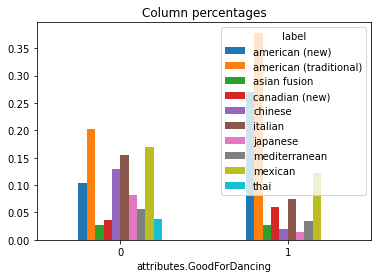

In [8]:
train["attributes.GoodForDancing"] = train["attributes.GoodForDancing"].fillna(value=0)
train["attributes.GoodForDancing"] = train["attributes.GoodForDancing"].apply(lambda x: 1 if x == "b'True'" else 0)

test["attributes.GoodForDancing"] = test["attributes.GoodForDancing"].fillna(value=0)
test["attributes.GoodForDancing"] = test["attributes.GoodForDancing"].apply(lambda x: 1 if x == "b'True'" else 0)

ct = rsm.cross_tabs(train, "label", "attributes.GoodForDancing")
ct.plot(output = "perc_col")


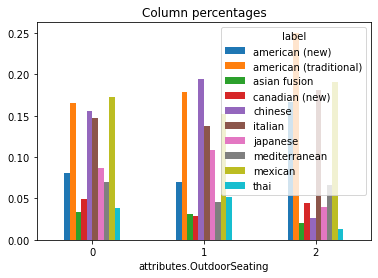

In [9]:
# OutdoorSeating: True -> 2; False -> 1; NaN & None -> 0
train["attributes.OutdoorSeating"] = train["attributes.OutdoorSeating"].fillna(value=0)
train["attributes.OutdoorSeating"] = train["attributes.OutdoorSeating"].apply(lambda x: 2 if x=="b'True'" else (1 if x=="b'False'" else 0))

ct = rsm.cross_tabs(train, "label", "attributes.OutdoorSeating")
ct.plot(output = "perc_col")

In [10]:
# Extract start and end hour on Saturday
#train["start_hour_Saturday"] = train["hours.Saturday"].str.extract(r"b'(\w{1,2})").astype(str)
#test["start_hour_Saturday"] = test["hours.Saturday"].str.extract(r"b'(\w{1,2})").astype(str)

#train["end_hour_Saturday"] = train["hours.Saturday"].str.extract(r"-(\w{1,2})").astype(str)
#test["end_hour_Saturday"] = test["hours.Saturday"].str.extract(r"-(\w{1,2})").astype(str)

train.drop(["hours.Saturday"], axis=1, inplace = True)
test.drop(["hours.Saturday"], axis=1, inplace = True)

In [11]:
# drop attributes.Corkage too many NaN
train.drop(["attributes.Corkage", "longitude"], axis=1, inplace = True)
test.drop(["attributes.Corkage", "longitude"], axis=1, inplace = True)

In [12]:
train["name"] = train["name"].str.extract(r"b[\'|\"]([A-Za-z-\s;:&]+)").astype(str)
test["name"] = test["name"].str.extract(r"b[\'|\"]([A-Za-z-\s;:&]+)").astype(str)

def pre_processing_by_nltk(doc, stemming = True, need_sent = False):
    # step 1: get sentences
    sentences = sent_tokenize(doc)
    # step 2: get tokens
    tokens = []
    for sent in sentences:
        words = word_tokenize(sent)
        # step 3 (optional): stemming
        if stemming:
            words = [ps.stem(word) for word in words]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
    return [w.lower() for w in tokens if w.lower() not in stop]

def appear_or_not(doc, vocab):
    tokens = pre_processing_by_nltk(doc)
    for i, token in enumerate(tokens):
        if token not in vocab:
            tokens[i] = '<UNK>'
    x = [0] * len(vocab)
    for token in set(tokens):
        token_id = vocab[token]
        x[token_id] = 1
    return x

In [13]:
DF = defaultdict(float)
for doc in tqdm(train["name"]):
    tokens = pre_processing_by_nltk(doc)
    for token in set(tokens):
        DF[token] += 1
        
IDF, vocab = dict(), dict()
for token in DF:
    if DF[token] < 15:
        # this becomes an unk
        pass
    else:
        vocab[token] = len(vocab)
        #IDF[token] = log(1 + len(df[1]) / DF[token])
vocab['<UNK>'] = len(vocab)

train_name = []
for doc in tqdm(train["name"]):
    train_name.append(appear_or_not(doc, vocab))

test_name = []
for doc in tqdm(test["name"]):
    test_name.append(appear_or_not(doc, vocab))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7513.49it/s]


In [14]:
train_vob = pd.DataFrame(train_name, columns = list(vocab.keys()))
test_vob = pd.DataFrame(test_name, columns = list(vocab.keys()))

train = pd.concat([train, train_vob], axis = 1)
test = pd.concat([test, test_vob], axis = 1)

In [15]:
# attributes.RestaurantsReservations: True -> 2; False -> 1; NaN & None -> 0
train["attributes.RestaurantsReservations"] = train["attributes.RestaurantsReservations"].fillna(value=0)
train["attributes.RestaurantsReservations"] = train["attributes.RestaurantsReservations"].apply(lambda x: 2 if x=="b'True'" else (1 if x=="b'False'" else 0))

test["attributes.RestaurantsReservations"] = test["attributes.RestaurantsReservations"].fillna(value=0)
test["attributes.RestaurantsReservations"] = test["attributes.RestaurantsReservations"].apply(lambda x: 2 if x=="b'True'" else (1 if x=="b'False'" else 0))

In [16]:
# Extract start and end hour on Friday
#train["start_hour_Friday"] = train["hours.Friday"].str.extract(r"b'(\w{1,2})").astype(str)
#test["start_hour_Friday"] = test["hours.Friday"].str.extract(r"b'(\w{1,2})").astype(str)

#train["end_hour_Friday"] = train["hours.Friday"].str.extract(r"-(\w{1,2})").astype(str)
#test["end_hour_Friday"] = test["hours.Friday"].str.extract(r"-(\w{1,2})").astype(str)

train.drop(["hours.Friday"], axis=1, inplace = True)
test.drop(["hours.Friday"], axis=1, inplace = True)

In [17]:
# Extract attributes.RestaurantsPriceRange2 number
train["attributes.RestaurantsPriceRange2"] = train["attributes.RestaurantsPriceRange2"].str.extract(r"b'(\d{1,2})").astype(float).fillna(0)
test["attributes.RestaurantsPriceRange2"] = test["attributes.RestaurantsPriceRange2"].str.extract(r"b'(\d{1,2})").astype(float).fillna(0)

In [18]:
train.drop(["attributes.WiFi", "attributes.ByAppointmentOnly", "attributes.Music", "attributes.NoiseLevel", "attributes.BYOB", "state", 
           "attributes.Alcohol"], axis=1, inplace = True)
test.drop(["attributes.WiFi","attributes.ByAppointmentOnly","attributes.Music","attributes.NoiseLevel", "attributes.BYOB", "state",
          "attributes.Alcohol"], axis=1, inplace = True)

In [19]:
# attributes.HasTV: True -> 2; False -> 1; NaN & None -> 0
train["attributes.HasTV"] = train["attributes.HasTV"].fillna(value=0)
train["attributes.HasTV"] = train["attributes.HasTV"].apply(lambda x: 2 if x=="b'True'" else (1 if x=="b'False'" else 0))

test["attributes.HasTV"] = test["attributes.HasTV"].fillna(value=0)
test["attributes.HasTV"] = test["attributes.HasTV"].apply(lambda x: 2 if x=="b'True'" else (1 if x=="b'False'" else 0))

In [20]:
train.drop(["attributes", "attributes.BYOBCorkage", "hours.Wednesday", "hours.Sunday","attributes.RestaurantsGoodForGroups",
           "attributes.Open24Hours", "attributes.BusinessParking", "attributes.DogsAllowed","attributes.HairSpecializesIn", 
            "review_count", "is_open","attributes.Caters", "attributes.CoatCheck", "attributes.BikeParking","hours.Monday",
           "attributes.WheelchairAccessible","city", "attributes.DriveThru","attributes.RestaurantsTakeOut","latitude",
           "attributes.Smoking","business_id","attributes.RestaurantsCounterService", "hours.Thursday",
            "attributes.RestaurantsAttire","attributes.BestNights","attributes.AcceptsInsurance","attributes.DietaryRestrictions",
           "attributes.BusinessAcceptsBitcoin","address","attributes.RestaurantsTableService","attributes.GoodForMeal",
           "hours"], axis=1, inplace = True)

test.drop(["attributes",'attributes.BYOBCorkage', "hours.Wednesday","hours.Sunday","attributes.RestaurantsGoodForGroups",
          "attributes.Open24Hours","attributes.BusinessParking", "attributes.DogsAllowed", "attributes.HairSpecializesIn",
           "review_count","is_open","attributes.Caters","attributes.CoatCheck","attributes.BikeParking","hours.Monday",
          "attributes.WheelchairAccessible","city","attributes.DriveThru","attributes.RestaurantsTakeOut","latitude",
          "attributes.Smoking","business_id","attributes.RestaurantsCounterService","hours.Thursday",
           "attributes.RestaurantsAttire","attributes.BestNights","attributes.AcceptsInsurance","attributes.DietaryRestrictions",
          "attributes.BusinessAcceptsBitcoin","address","attributes.RestaurantsTableService","attributes.GoodForMeal",
          "hours"], axis=1, inplace = True)

In [21]:
# attributes.RestaurantsDelivery: True -> 1; False -> 0
train["attributes.RestaurantsDelivery"] = train["attributes.RestaurantsDelivery"].fillna(value=0)
train["attributes.RestaurantsDelivery"] = train["attributes.RestaurantsDelivery"].apply(lambda x: 1 if x=="b'True'" else 0)

test["attributes.RestaurantsDelivery"] = test["attributes.RestaurantsDelivery"].fillna(value=0)
test["attributes.RestaurantsDelivery"] = test["attributes.RestaurantsDelivery"].apply(lambda x: 1 if x=="b'True'" else 0)

In [22]:
# attributes.GoodForKids: True -> 1; False -> 0; NaN & None -> 0
train["attributes.GoodForKids"] = train["attributes.GoodForKids"].fillna(value=0)
train["attributes.GoodForKids"] = train["attributes.GoodForKids"].apply(lambda x: 1 if x=="b'True'" else 0)

test["attributes.GoodForKids"] = test["attributes.GoodForKids"].fillna(value=0)
test["attributes.GoodForKids"] = test["attributes.GoodForKids"].apply(lambda x: 1 if x=="b'True'" else 0)

In [23]:
train

,id,attributes.HappyHour,attributes.GoodForDancing,attributes.OutdoorSeating,name,attributes.RestaurantsReservations,attributes.RestaurantsPriceRange2,attributes.HasTV,stars,attributes.RestaurantsDelivery,attributes.GoodForKids,label,review,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual,inn,-,mexican,food,bell,taco,red,bowl,grand,caf,tequila,&,pasta,compani,rubio,egg,noodl,thai,tea,restaur,green,el,buffet,chines,italian,eateri,tavern,hous,panda,express,burrito,super,jimmi,greek,grill,asian,steakhous,black,wing,hut,pizza,tast,bakeri,popey,louisiana,kitchen,sushi,island,hot,villag,pot,hakka,garden,place,cafe,torta,taqueria,cantina,la,mexico,citi,bar,loco,casa,roberto,queen,hotel,le,chipotl,cuisin,beer,lobster,burger,sub,one,tokyo,wok,boston,bbq,applebe,china,breweri,market,pub,teriyaki,origin,kong,hong,chalet,swiss,rotisseri,ristorant,mi,king,pho,gourmet,mucho,bistro,sport,da,pizzeria,street,paradis,river,mediterranean,il,barro,e,basil,japanes,golden,tabl,harvey,n,osteria,gyro,brew,mama,new,eat,qdoba,sunset,chili,big,palac,jade,del,store,countri,barrel,old,izakaya,de,watch,first,marisco,chicken,club,chef,l,loung,joe,denni,dragon,spici,lucki,dumpl,time,guy,five,deli,fat,san,wong,kabob,york,best,trattoria,fine,sun,robin,diner,brother,ramen,american,fiesta,oliv,rocket,johnni,wild,ming,orient,famou,north,dickey,pollo,fresh,nan,co,shop,mr,vega,lo,steak,littl,dog,baja,chez,great,fusion,bella,room,kfc,sonic,drive-in,john,seafood,boy,star,di,shawarma,bro,wine,roadhous,dine,sandwich,hill,famili,cocina,papa,filiberto,st,cater,evan,bob,domino,blue,lee,south,szechuan,phoenix,j,saloon,fire,east,cucina,ii,coffe,west,toni,rose,captain,park,corner,villa,fish,factori,pita,pit,sweet,sum,dim,buffalo,pie,hibachi,fu,go,roll,box,shanghai,rice,mia,urban,legend,amigo,fox,tap,hunan,moe,rock,sam,roma,town,happi,al,conge,station,mandarin,rubi,falafel,korean,jack,style,<UNK>
0,0,2,0,1,Rush Inn,1,2.0,2,4.0,0,0,american (traditional),"So, we stopped here on our way to the Side Que...",0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,2,GreenMix,1,2.0,1,3.5,0,1,american (new),This is our go-to healthy spot! The food is al...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,BarBurrito - Gerrard,1,0.0,0,3.0,0,0,mexican,Food court meal at Gerrard Square. It's been ...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,0,0,1,SalvaMex,1,1.0,2,4.0,1,1,mexican,"Located on Rainbow/Charleston, this small f

In [24]:
train = pd.concat(
    [
        train,
        pd.get_dummies(train["attributes.HappyHour"], prefix='HappyHour', drop_first = True),
        pd.get_dummies(train["attributes.OutdoorSeating"], prefix='OutdoorSeat', drop_first = True),
        pd.get_dummies(train["attributes.RestaurantsReservations"], prefix='Revervation', drop_first = True),
        pd.get_dummies(train["attributes.HasTV"], prefix='HasTV', drop_first = True)
        ],
    axis = 1   
)

test = pd.concat(
    [
        test,
        pd.get_dummies(test["attributes.HappyHour"], prefix='HappyHour', drop_first = True),
        pd.get_dummies(test["attributes.OutdoorSeating"], prefix='OutdoorSeat', drop_first = True),
        pd.get_dummies(test["attributes.RestaurantsReservations"], prefix='Revervation', drop_first = True),
        pd.get_dummies(test["attributes.HasTV"], prefix='HasTV', drop_first = True)
        ],
    axis = 1   
)

train.drop(["attributes.HappyHour", "attributes.OutdoorSeating","attributes.RestaurantsReservations","attributes.HasTV"], axis=1, inplace = True)
test.drop(["attributes.HappyHour", "attributes.OutdoorSeating","attributes.RestaurantsReservations","attributes.HasTV"], axis=1, inplace = True)


In [25]:
test

,id,attributes.GoodForDancing,name,attributes.RestaurantsPriceRange2,stars,attributes.RestaurantsDelivery,attributes.GoodForKids,review,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual,inn,-,mexican,food,bell,taco,red,bowl,grand,caf,tequila,&,pasta,compani,rubio,egg,noodl,thai,tea,restaur,green,el,buffet,chines,italian,eateri,tavern,hous,panda,express,burrito,super,jimmi,greek,grill,asian,steakhous,black,wing,hut,pizza,tast,bakeri,popey,louisiana,kitchen,sushi,island,hot,villag,pot,hakka,garden,place,cafe,torta,taqueria,cantina,la,mexico,citi,bar,loco,casa,roberto,queen,hotel,le,chipotl,cuisin,beer,lobster,burger,sub,one,tokyo,wok,boston,bbq,applebe,china,breweri,market,pub,teriyaki,origin,kong,hong,chalet,swiss,rotisseri,ristorant,mi,king,pho,gourmet,mucho,bistro,sport,da,pizzeria,street,paradis,river,mediterranean,il,barro,e,basil,japanes,golden,tabl,harvey,n,osteria,gyro,brew,mama,new,eat,qdoba,sunset,chili,big,palac,jade,del,store,countri,barrel,old,izakaya,de,watch,first,marisco,chicken,club,chef,l,loung,joe,denni,dragon,spici,lucki,dumpl,time,guy,five,deli,fat,san,wong,kabob,york,best,trattoria,fine,sun,robin,diner,brother,ramen,american,fiesta,oliv,rocket,johnni,wild,ming,orient,famou,north,dickey,pollo,fresh,nan,co,shop,mr,vega,lo,steak,littl,dog,baja,chez,great,fusion,bella,room,kfc,sonic,drive-in,john,seafood,boy,star,di,shawarma,bro,wine,roadhous,dine,sandwich,hill,famili,cocina,papa,filiberto,st,cater,evan,bob,domino,blue,lee,south,szechuan,phoenix,j,saloon,fire,east,cucina,ii,coffe,west,toni,rose,captain,park,corner,villa,fish,factori,pita,pit,sweet,sum,dim,buffalo,pie,hibachi,fu,go,roll,box,shanghai,rice,mia,urban,legend,amigo,fox,tap,hunan,moe,rock,sam,roma,town,happi,al,conge,station,mandarin,rubi,falafel,korean,jack,style,<UNK>,HappyHour_1,HappyHour_2,OutdoorSeat_b'None',OutdoorSeat_b'True',Revervation_1,Revervation_2,HasTV_1,HasTV_2
0,0,0,Fuse,2.0,4.5,0,0,Overall wonderful experience. \n\nThe owner Fa...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1
1,1,0,Vicky,2.0,3.0,0,1,"VIBE: Nieghbourhood hole. TV playing sports, p...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
2,2,0,Viet House,1.0,3.5,0,1,"Viet House is very good. The food was fresh, ...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,3,0,Thai Boat,2.0,3.0,0,1,This is a really good place. Not truly authent...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

In [26]:
def build_vocab(sentences):
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

In [27]:
def get_embeddings(inp_data, vocabulary_inv, size_features=320,
                   mode='skipgram',
                   min_word_count=10,
                   context=25):
    model_name = "embedding"
    model_name = os.path.join(model_name)
    num_workers = 15  # Number of threads to run in parallel
    downsampling = 1e-3  # Downsample setting for frequent words
    print('Training Word2Vec model...')
    # use inp_data and vocabulary_inv to reconstruct sentences
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    if mode == 'skipgram':
        sg = 1
        print('Model: skip-gram')
    elif mode == 'cbow':
        sg = 0
        print('Model: CBOW')
    embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                        sg=sg,
                                        vector_size=size_features,
                                        min_count=min_word_count,
                                        window=context,
                                        sample=downsampling)
    print("Saving Word2Vec model {}".format(model_name))
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25,
                                                     embedding_model.vector_size)
    return embedding_weights

In [28]:
def preprocess_df(df):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    # prepare translation table to translate punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row["text"]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    df["text"] = preprocessed_sentences
    return df

In [29]:
data_path = ""

df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

df_train["text"] = train["name"] + " " + df_train["review"]
df_test["text"] =  test["name"] + " " + df_test["review"] 
df_train = preprocess_df(df_train)
df_test = preprocess_df(df_test)

In [30]:
# tokenization 
tagged_data = [word_tokenize(_d) for i, _d in enumerate(df_train["text"])]
# build vocabulary from tokenized data
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_data)
# use the above mapping to create input data
inp_data = [[vocabulary[word] for word in text] for text in tagged_data]
# get embedding vector
embedding_weights = get_embeddings(inp_data, vocabulary_inv)

Training Word2Vec model...
Model: skip-gram
Saving Word2Vec model embedding


In [31]:
train_review = [word_tokenize(_d) for i, _d in enumerate(df_train["text"])]
test_review = [word_tokenize(_d) for i, _d in enumerate(df_test["text"])]

In [32]:
train_vec = []
for doc in train_review:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    vec = vec / len(doc)
    train_vec.append(vec)

test_vec = []
for doc in test_review:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            continue
    vec = vec / length
    test_vec.append(vec)

In [33]:
train = pd.concat([train,pd.DataFrame(train_vec)],axis = 1)
test = pd.concat([test,pd.DataFrame(test_vec)],axis = 1)

In [34]:
train_id = train["id"]
test_id = test["id"]
train.drop(["id","name"], axis=1, inplace = True)
test.drop(["id","name"], axis=1, inplace = True)

train_label = train["label"]

train.drop(["label", "review"], axis=1, inplace = True)
test.drop(["review"], axis=1, inplace = True)

In [35]:
test

,attributes.GoodForDancing,attributes.RestaurantsPriceRange2,stars,attributes.RestaurantsDelivery,attributes.GoodForKids,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual,inn,-,mexican,food,bell,taco,red,bowl,grand,caf,tequila,&,pasta,compani,rubio,egg,noodl,thai,tea,restaur,green,el,buffet,chines,italian,eateri,tavern,hous,panda,express,burrito,super,jimmi,greek,grill,asian,steakhous,black,wing,hut,pizza,tast,bakeri,popey,louisiana,kitchen,sushi,island,hot,villag,pot,hakka,garden,place,cafe,torta,taqueria,cantina,la,mexico,citi,bar,loco,casa,roberto,queen,hotel,le,chipotl,cuisin,beer,lobster,burger,sub,one,tokyo,wok,boston,bbq,applebe,china,breweri,market,pub,teriyaki,origin,kong,hong,chalet,swiss,rotisseri,ristorant,mi,king,pho,gourmet,mucho,bistro,sport,da,pizzeria,street,paradis,river,mediterranean,il,barro,e,basil,japanes,golden,tabl,harvey,n,osteria,gyro,brew,mama,new,eat,qdoba,sunset,chili,big,palac,jade,del,store,countri,barrel,old,izakaya,de,watch,first,marisco,chicken,club,chef,l,loung,joe,denni,dragon,spici,lucki,dumpl,time,guy,five,deli,fat,san,wong,kabob,york,best,trattoria,fine,sun,robin,diner,brother,ramen,american,fiesta,oliv,rocket,johnni,wild,ming,orient,famou,north,dickey,pollo,fresh,nan,co,shop,mr,vega,lo,steak,littl,dog,baja,chez,great,fusion,bella,room,kfc,sonic,drive-in,john,seafood,boy,star,di,shawarma,bro,wine,roadhous,dine,sandwich,hill,famili,cocina,papa,filiberto,st,cater,evan,bob,domino,blue,lee,south,szechuan,phoenix,j,saloon,fire,east,cucina,ii,coffe,west,toni,rose,captain,park,corner,villa,fish,factori,pita,pit,sweet,sum,dim,buffalo,pie,hibachi,fu,go,roll,box,shanghai,rice,mia,urban,legend,amigo,fox,tap,hunan,moe,rock,sam,roma,town,happi,al,conge,station,mandarin,rubi,falafel,korean,jack,style,<UNK>,HappyHour_1,HappyHour_2,OutdoorSeat_b'None',OutdoorSeat_b'True',Revervation_1,Revervation_2,HasTV_1,HasTV_2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
0,0,2.0,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0.069316,-0.060351,0.048631,0.029568,-0.138481,0.058834,0.028571,-0.020428,0.013657,-0.103392,-0.001806,-0.129674,-0.083742,-0.029949,-0.167527,0.168211,-0.286429,-0.017670,-0.014181,-0.072624,0.031192,0.064033,0.053206,-0.030572,0.030512,0.047645,-0.022242,0.000643,-0.017438,0.038305,0.002088,-0.063066,-0.020507,-0.091878,-0.014828,-0.09236

In [36]:
train = np.array(train)
test = np.array(test)

In [37]:
clf = LogisticRegression(C = 15, penalty = "l2", max_iter=100000000, solver = "lbfgs").fit(train, train_label)
preds = clf.predict(test)

In [38]:
dic = {"Id": [], "Predicted": []}
for i, pred in enumerate(preds):
    dic["Id"].append(i)
    dic["Predicted"].append(pred)

dic_df = pd.DataFrame.from_dict(dic)
dic_df.to_csv(data_path + "predicted.csv", index=False)